In [12]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

In [13]:
def extract_variable(fname,var_name='zeta_max'):
    # Open the netCDF file
    f = nc.Dataset(fname, 'r')

    # Print the metadata
    #print(f)

    # Print the dimensions
    #for d in f.dimensions:
    #    print(d, f.dimensions[d].size)

    # Print the variables
    #for v in f.variables:
    #    print(v, f.variables[v].shape)

    #let's see if we can put a mask and plot wet/dry region
    zeta_max = f.variables[var_name]
    # Get the fill value
    fill_value = zeta_max._FillValue

    #dump to a numpy array and then close files
    z_arr = np.array(zeta_max[:])

    f.close()

    return fill_value,z_arr

def find_wet_nodes(z_arr,fill_value):
    #this is the indeces of dry nodes
    mask = z_arr!=fill_value
    wet_nodes = np.where(mask)[0]

    return mask,wet_nodes

def retrieve_elements(fname):
    f = nc.Dataset(fname, 'r')
    #let's see if we can put a mask and plot wet/dry region
    els = f.variables['element']
    el_arr = np.array(els[:])
    f.close()
    return el_arr

def retrieve_nodes(fname):
    f = nc.Dataset(fname, 'r')
    #get nodes x and y location
    nodex = np.array(f.variables['x'][:])
    nodey = np.array(f.variables['y'][:])
    return nodex,nodey

def plot_mesh(x,y,tri):
    # Create a Triangulation object
    triangulation = Triangulation(x, y, tri)
    # Plot the mesh
    plt.triplot(triangulation)
    plt.show()

#plot_func(node_x,node_y,eles[ele_mask],compound_zeta_max,min_lon,max_lon,min_lat,max_lat,~compound_mask)
def plot_func(x,y,tri,fvalues,xmin,xmax,ymin,ymax,dry_mask,title_tex='Thresholding Plot',fnme='0',nds=2):
    triangulation = Triangulation(x, y, tri)
    mask = np.any(np.where(dry_mask[triangulation.triangles], True, False), axis=1)
    #mask the dry elements
    triangulation.set_mask(mask)
    #plt.tricontourf(triangulation,fvalues,levels=[0,1,2,3,4,5,6],vmin=0,vmax=5)
    #messing with color palette
    plt.figure(figsize=(14, 10))
    #for all the plots
    if nds==4:
        plt.tricontourf(triangulation,fvalues,[0,1,2,3,4], colors = ['r','gray','b','w'])#,'b','y','magenta'])#,vmin=0,vmax=10)
    if nds==2:
        plt.tricontourf(triangulation,fvalues,[0,1,2], colors = ['gray','b'])#,'b','y','magenta'])#,vmin=0,vmax=10)
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.xlabel('Lon (deg)')
    plt.ylabel('Lat (deg)')
    plt.title(title_tex)
    plt.colorbar()
    if fnme!='0':
        plt.savefig(fnme)
    plt.show()

def within_box(node_x,node_y,x_min,x_max,y_min,y_max):
    mask1 = np.logical_and(np.logical_and(np.logical_and(node_x >= x_min, node_x <= x_max),node_y >= y_min) ,node_y <= y_max)
    return mask1,np.where(mask1)[0]
def extract_elements(tri,valid_nodes):
    #see if each element contains all nodes within box
    mask1=valid_nodes[tri[:,0]]
    mask2=valid_nodes[tri[:,1]]
    mask3=valid_nodes[tri[:,2]]

    #mask = np.logical_or(np.logical_or(mask1,mask2),mask3)
    mask = np.any(np.where(valid_nodes[tri], True, False), axis=1)
    return mask,np.where(mask)[0]


In [19]:
#read in one file and see contents
fnames = ['Nicholas_compound_maxele.nc','Nicholas_rivers_maxele.nc','Nicholas_surge_maxele.nc']

fill_val,compound_zeta_max = extract_variable(fnames[0])
fill_val,rivers_zeta_max = extract_variable(fnames[1])
fill_val,surge_zeta_max = extract_variable(fnames[2])

#identify dry regions
compound_wd_mask,compound_wet_nodes=find_wet_nodes(compound_zeta_max,fill_val)
rivers_wd_mask,rivers_wet_nodes=find_wet_nodes(rivers_zeta_max,fill_val)
surge_wd_mask,surge_wet_nodes=find_wet_nodes(surge_zeta_max,fill_val)
#intersect of dry regions
mask1 = np.logical_and(~compound_wd_mask,~surge_wd_mask)
mask2 = np.logical_and(~compound_wd_mask,~rivers_wd_mask)
#mask3 is nodes which are dry in all cases
mask3= np.logical_and(mask1,mask2)

In [20]:
#truncate things within a box (get region from Amin later)
#bounding box
min_lon = -95.5
max_lon = -93.5
min_lat = 28.5
max_lat = 30.5
#can we visualize within a box? Also assuming meshes are same between simulations
eles = retrieve_elements(fnames[0])
#for python purposes
eles = eles-1
#get nodes
node_x,node_y = retrieve_nodes(fnames[0])
#extract nodes that lie within the bounding box
node_mask,node_nums = within_box(node_x,node_y,min_lon,max_lon,min_lat,max_lat)
#extract elements that lie completely within this box
ele_mask,ele_nums = extract_elements(eles,node_mask)




#we want to find region between compound, surge, and compound, rivers that is within epsilon
epsilon = 0.05


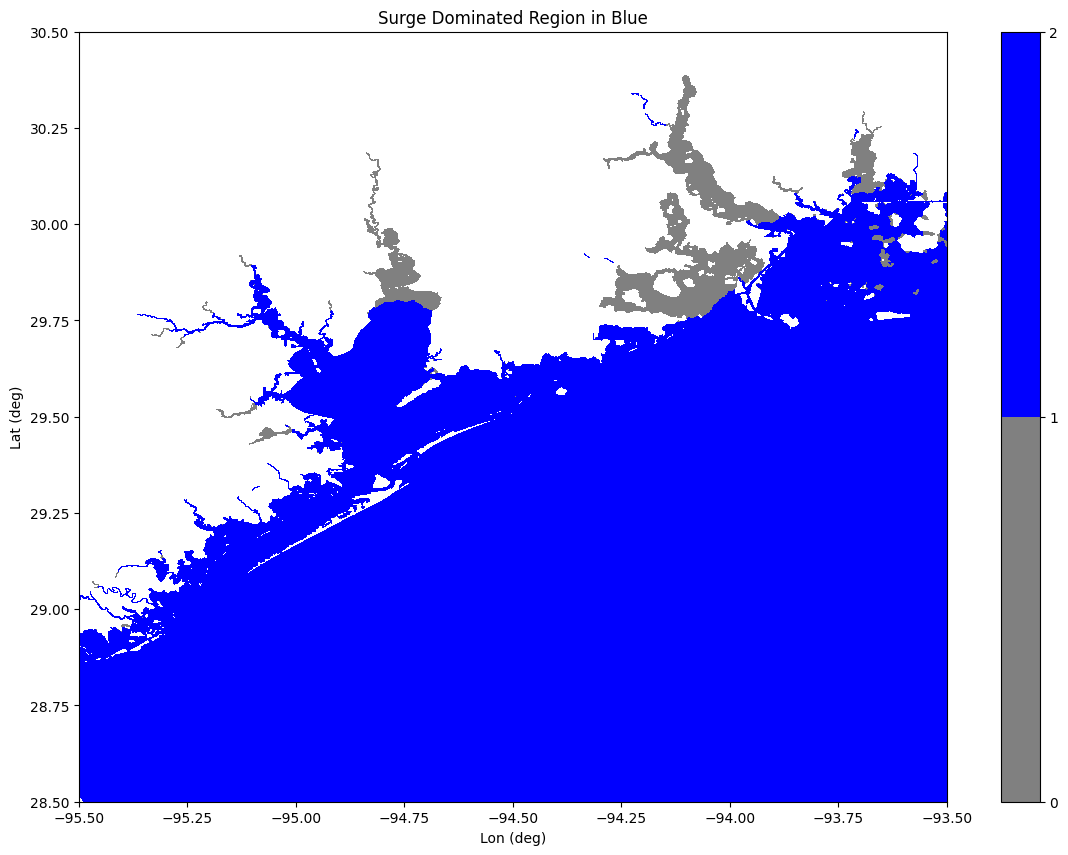

In [21]:
#plot the special region for surge vs compound
#this represents the region that is most impacted by including rivers
compound_vs_surge = np.zeros(compound_zeta_max.shape)
surge_mask=np.absolute((compound_zeta_max-surge_zeta_max)/compound_zeta_max)<epsilon
#if surge is dry, we dont want to count
surge_mask=np.logical_and(surge_mask,surge_wd_mask)
compound_vs_surge[surge_mask]=1
dry_mask = np.zeros(compound_zeta_max.shape)
plot_func(node_x,node_y,eles[ele_mask],compound_vs_surge,min_lon,max_lon,min_lat,max_lat,mask1,title_tex='Surge Dominated Region in Blue',fnme='SurgevsCompound.png')

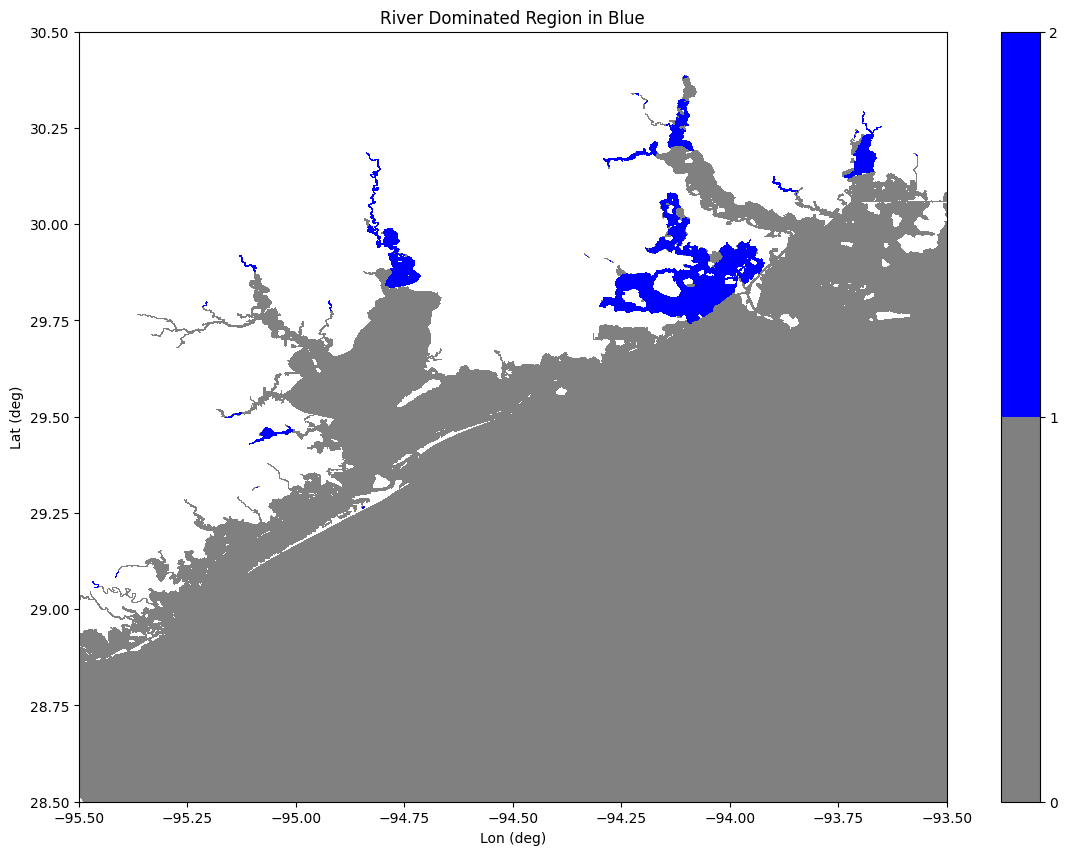

In [22]:
#plot the special region for rivers vs compound
#this is the region that is most impacted by surge
rivers_vs_compound = np.zeros(compound_zeta_max.shape)
rivers_mask=np.absolute((compound_zeta_max-rivers_zeta_max)/compound_zeta_max)<epsilon
#if surge is dry, we dont want to count
rivers_mask=np.logical_and(rivers_mask,rivers_wd_mask)
rivers_vs_compound[rivers_mask]=1

dry_mask = np.zeros(compound_zeta_max.shape)
plot_func(node_x,node_y,eles[ele_mask],rivers_vs_compound,min_lon,max_lon,min_lat,max_lat,mask2,title_tex='River Dominated Region in Blue',fnme='RiversevsCompound.png')

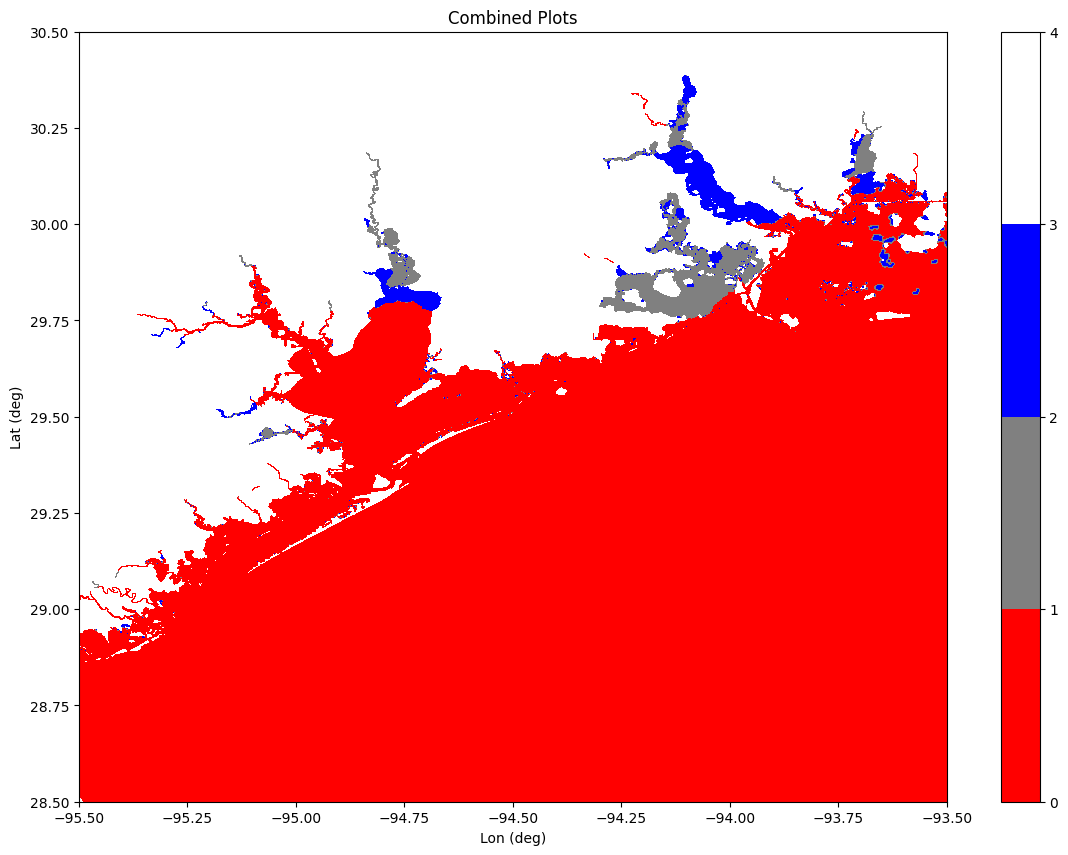

In [25]:
#find intersection of 2 demarcated regions, this is our transition zone

region_of_interest = np.logical_and(compound_vs_surge==0,rivers_vs_compound==0)
#we want to ignore dry regions as well...
region_of_interest = np.logical_and(region_of_interest,~mask3)

#these are the leftover components
surge_region = np.logical_and(np.logical_not(region_of_interest),compound_vs_surge)
river_region = np.logical_and(np.logical_not(region_of_interest),rivers_vs_compound)

final_plot_vals = np.ones(compound_zeta_max.shape)*3.5
final_plot_vals[region_of_interest] = 2.5
final_plot_vals[river_region] = 1.5
final_plot_vals[surge_region] = 0.5
#4 is the default, not flooded in all cases
#3 is compound zone
#2 is river dominated zone
#1 is surge dominated zone
plot_func(node_x,node_y,eles[ele_mask],final_plot_vals,min_lon,max_lon,min_lat,max_lat,mask3,nds=4,title_tex='Combined Plots',fnme='SurgevsCompoundvsRiver.png')

In [46]:
###############################
#Rest of notebook is just testing random stuff, please ignore
###############################
#the remainder on plotting the difference in wet vs dry regions

compound_mask,compound_wet_nodes=find_wet_nodes(compound_zeta_max,fill_val)
rivers_mask,rivers_wet_nodes=find_wet_nodes(rivers_zeta_max,fill_val)
surge_mask,surge_wet_nodes=find_wet_nodes(surge_zeta_max,fill_val)

#can we visualize?

print(compound_wet_nodes.size)
print(rivers_wet_nodes.size)
print(surge_wet_nodes.size)

#are these all the same
print(np.array_equal(compound_wet_nodes, rivers_wet_nodes))
print(np.array_equal(compound_wet_nodes, surge_wet_nodes))
print(np.array_equal(rivers_wet_nodes, surge_wet_nodes))

#check if values are or not
print(np.array_equal(compound_zeta_max[compound_wet_nodes], rivers_zeta_max[rivers_wet_nodes]))
print(np.array_equal(surge_zeta_max[surge_wet_nodes], rivers_zeta_max[rivers_wet_nodes]))

5711964
4807431
5674411
False
False
False
False
False


In [47]:
#can we visualize within a box?
eles = retrieve_elements(fnames[0])
#for python purposes
eles = eles-1
#get nodes
node_x,node_y = retrieve_nodes(fnames[0])

#bounding box
min_lon = -95.5
max_lon = -93.5
min_lat = 28.5
max_lat = 30.5

#extract nodes that lie within the bounding box
node_mask,node_nums = within_box(node_x,node_y,min_lon,max_lon,min_lat,max_lat)
#extract elements that lie completely within this box
ele_mask,ele_nums = extract_elements(eles,node_mask)
print(ele_nums.shape)
print(ele_mask.shape)

#plot mesh test
#plot_mesh(node_x,node_y,eles[ele_mask])

(1111959,)
(15459336,)


-13.616


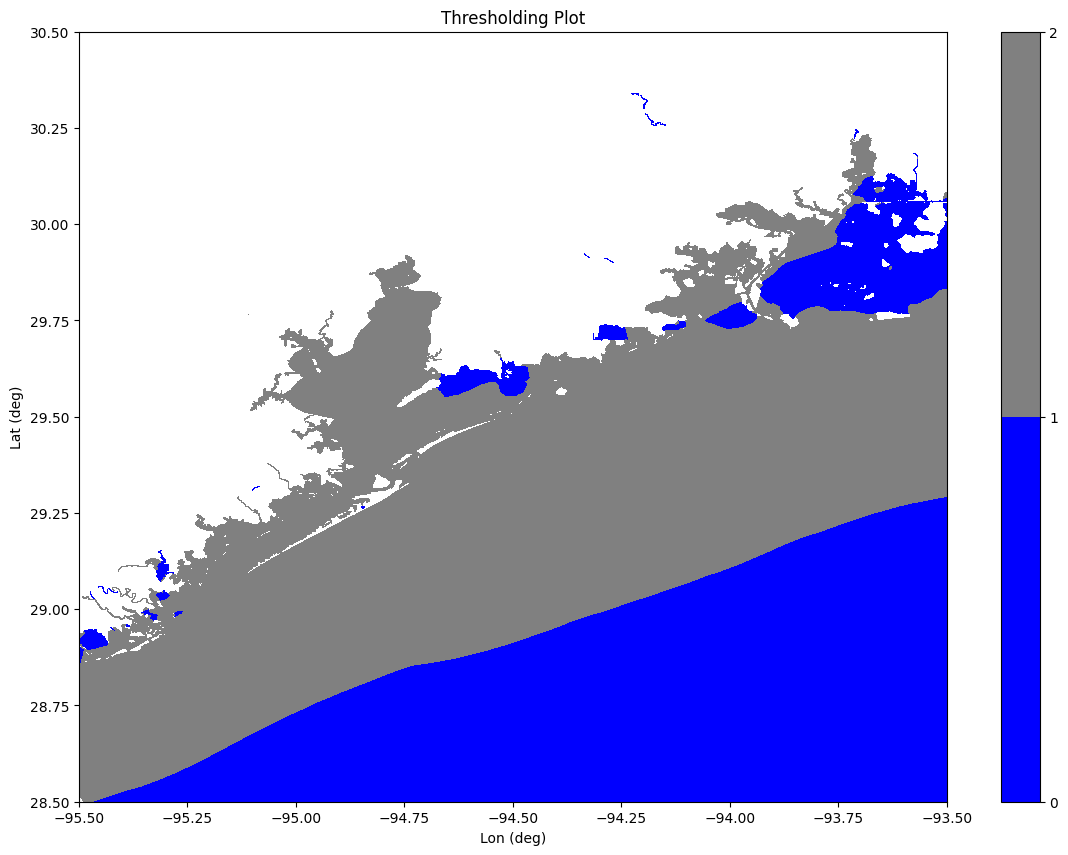

In [48]:
#compound_zeta_max[~compound_mask] = -0.01
print(np.amin(compound_zeta_max[compound_mask]))
plot_func(node_x,node_y,eles[ele_mask],compound_zeta_max,min_lon,max_lon,min_lat,max_lat,~compound_mask)

15693
936059


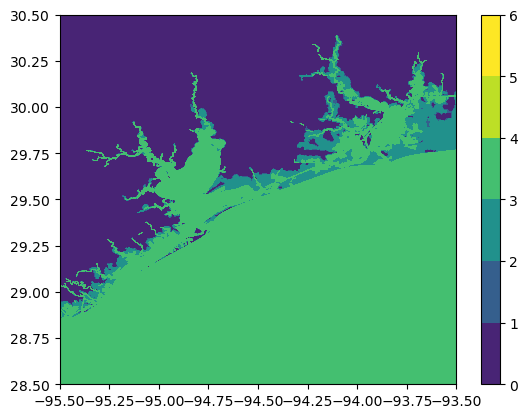

In [ ]:
#make a function that sets 1 if the maxele is wet in compound only
# 2 if compound+river
# 3 if compound+river+surge

#red is dry in all cases
#green is wet in one case
#
no_nodes = np.zeros(compound_mask.size,dtype=bool)
zones_func = surge_mask.astype(int)+compound_mask.astype(int)+rivers_mask.astype(int)
print(zones_func[zones_func==1].size)
print(zones_func[zones_func==2].size)
plot_func(node_x,node_y,eles[ele_mask],zones_func,min_lon,max_lon,min_lat,max_lat,no_nodes)